# Negative Binomial Regression

In [62]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from IPython.display import Image, display

## Introduction

In the Poisson regression model notebook we saw that the model was inadequate for modeling our bicyclist dataset.
The low performance of th dataset was because the data did not obey the **variance=mean** criterion of Poisson regression.

The goal of this notebook is to build upon the Poisson regression notebook and relax the equi-dispersion criterion.

This is often the case in real world data.
* variance > mean: over-dispersion
* variance < mean: under-dispersion

The Negative Binomial (NB) model is a model that relaxes the equi-dispersion assumption.

NB expresses variance in terms of the mean and requires us to define a new parameter $\alpha$.

$Variance = mean + \alpha*mean^p$

**When p=1 we refer to it as the NB1 model where:**

$Variance = (1+\alpha)*mean$

**When p=2 we refer to it as the NB2 model where:**

$Variance = mean + \alpha*mean^2$


## Regression strategy

How do we find the correct value for a parameter $\alpha?$
A technique called auxiliary OLS regression without a constant can help.

1. Data cleansing and feature engineering
2. Fit Poisson regression model on the dataset as in Poisson regression notebook.
This will give us the vector of fitted rate $\lambda_i$.
3. Fit the aux OLS regression model on the dataset. This will give us a value for $\alpha$.
4. Use $\alpha$ from step 3 to fit the NB2 regression model to the dataset.
5. Use the fitted NB2 model to make predictions about the expected counts on the test dataset.
6. Test goodness-of-fit of the NB2 model.

## Step 1
**Data cleansing and feature engineering**

In [63]:
# read data from url into dataframe
url = (
    "https://gist.githubusercontent.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe/" +
    "raw/7a5131d3f02575668b3c7e8c146b6a285acd2cd7/nyc_bb_bicyclist_counts.csv"
)

df = pd.read_csv(url)

# convert Date column from object to datetime64
df["Date"] = pd.to_datetime(df["Date"])

# create month, day_of_week and day features
df["MONTH"] = df["Date"].dt.month
df["DAYOFWEEK"] = df["Date"].dt.dayofweek
df["DAY"] = df["Date"].dt.day

# set date as index
df = df[["Date", "BB_COUNT", "MONTH","DAYOFWEEK", "DAY", "HIGH_T", "LOW_T", "PRECIP" ]]
df = df.rename(columns=({"Date": "DATE"}))
df = df.set_index("DATE")

display(df.head(2))

# using an alternative method from sklearn
mask =np.random.rand(len(df)) < 0.8

df_train = df[mask].copy()
df_test = df[~mask].copy()

print(f"Length of training dataset: {len(df_train)}")
print(f"Length of test dataset: {len(df_test)}")

# create regression expression in patsy notation
expr = """BB_COUNT ~ DAY + DAYOFWEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

# break df_train into y_train, X_train
y_train, X_train = dmatrices(expr, df_train, return_type="dataframe")

# break df_test into y_test, X_test
y_test, X_test = dmatrices(expr, df_test, return_type="dataframe")


,BB_COUNT,MONTH,DAYOFWEEK,DAY,HIGH_T,LOW_T,PRECIP
DATE,,,,,,,
2017-04-01,606,4,5,1,46.0,37.0,0.0
2017-04-02,2021,4,6,2,62.1,41.0,0.0


Length of training dataset: 164
Length of test dataset: 50


## Step 2
**Fit Poisson regression model on the dataset as in Poisson regression notebook.
This will give us the vector of fitted rate $\lambda_i$.**


In [64]:
poisson = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  164
Model:                            GLM   Df Residuals:                      157
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11339.
Date:                Sun, 14 Feb 2021   Deviance:                       21091.
Time:                        18:58:20   Pearson chi2:                 2.08e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1480      0.013    560.298      0.0

Our interest lies in the vector of fitted rates $\lambda$ produced by the training.


In [65]:
poisson_lambdas = poisson.mu
print(f"Length of fitted rates: {len(poisson_lambdas)}")
print(f"Example of 3 fitted rates: {poisson_lambdas[:3]}")

Length of fitted rates: 164
Example of 3 fitted rates: [1982.87920819 2651.74289299  854.85683222]


## Step 3
Fit the aux OLS regression model on the dataset. This will give us a value for $\alpha$.

A clever means to calculate α using a technique called auxiliary OLS regression without a constant.
The regression equation is as follows:

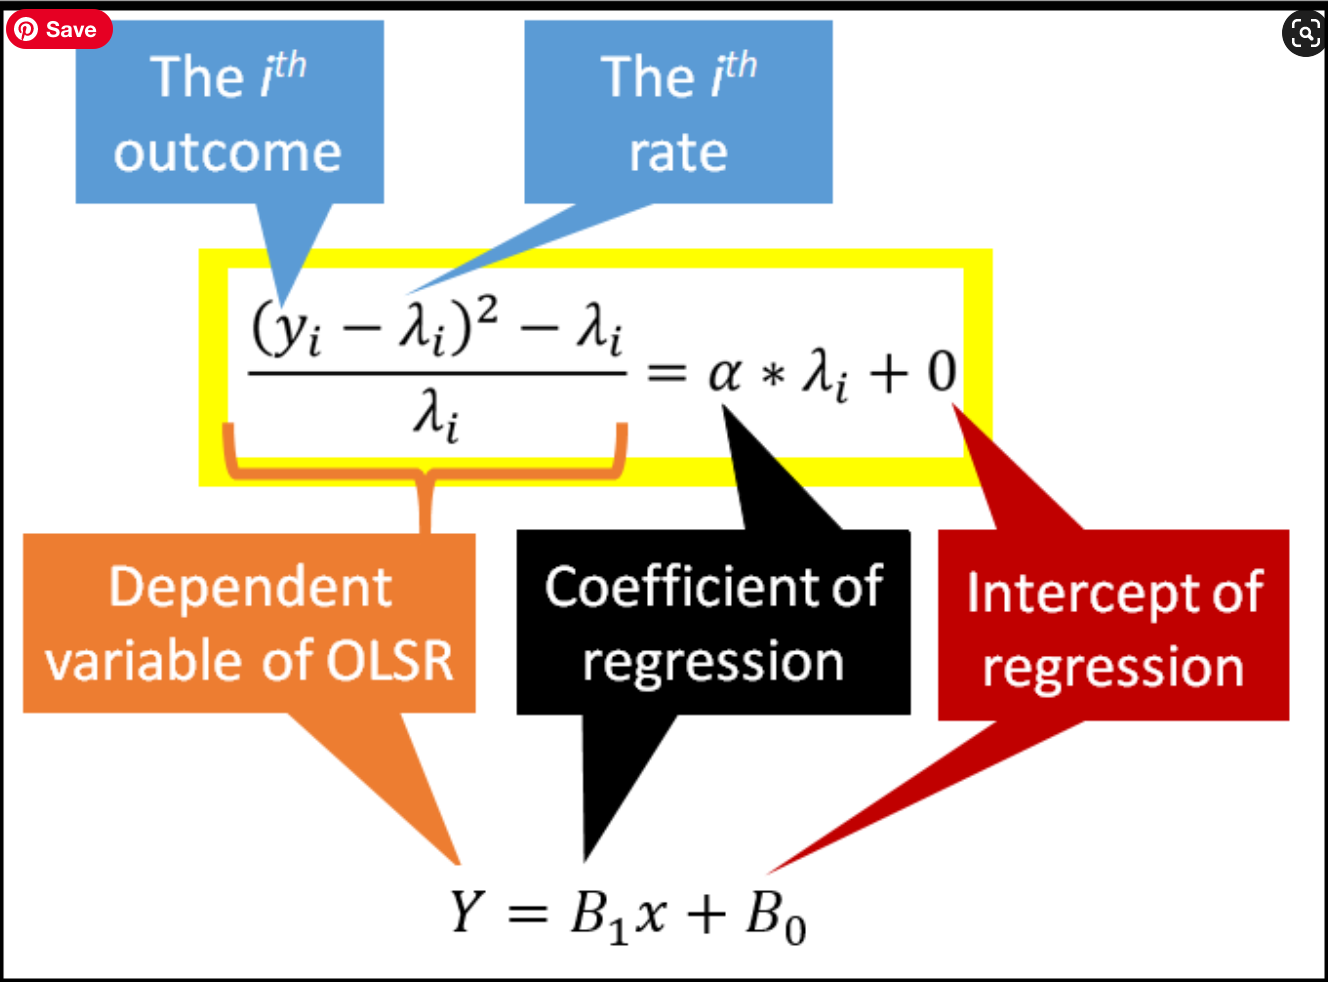

In [66]:
Image(filename="../resources/images/negative_binomial_regression.png", width=700)

You can at once see the relationship of the aux OLS equation with the straight line regression equation:
$Y = B_1*X + B_0$.

Add the λ vector as a new column called ‘BB_LAMBDA’ to the Data Frame of the training data set.
Recollect that λ’s dimensions are (n x 1). In our example it will be (161 x 1). Also recollect that the λ vector
is available in step 2.

In [67]:
df_train["BB_LAMBDA"] = poisson_lambdas

df_train.head(3)

,BB_COUNT,MONTH,DAYOFWEEK,DAY,HIGH_T,LOW_T,PRECIP,BB_LAMBDA
DATE,,,,,,,,
2017-04-01,606,4,5,1,46.0,37.0,0.00,1982.879208
2017-04-02,2021,4,6,2,62.1,41.0,0.00,2651.742893
2017-04-04,723,4,1,4,51.1,46.0,1.18,854.856832


Add a derived column called ‘AUX_OLS_DEP’ to the pandas Data Frame. This new column will store the values of
the dependent variable of the OLS regression. It is the left-hand side of the OLS regression equation above.

In [68]:
df_train["AUX_OLS_DEP"] = (
        ((df_train["BB_COUNT"] - df_train["BB_LAMBDA"])**2 - df_train["BB_LAMBDA"])
        /df_train["BB_LAMBDA"]
)

df_train.head(3)

,BB_COUNT,MONTH,DAYOFWEEK,DAY,HIGH_T,LOW_T,PRECIP,BB_LAMBDA,AUX_OLS_DEP
DATE,,,,,,,,,
2017-04-01,606,4,5,1,46.0,37.0,0.00,1982.879208,955.082623
2017-04-02,2021,4,6,2,62.1,41.0,0.00,2651.742893,149.028345
2017-04-04,723,4,1,4,51.1,46.0,1.18,854.856832,19.338171


Use patsy to form the model specification for the OLSR.
We want to tell patsy that AUX_OLS_DEP is the dependent variable,
and it is explained by BB_LAMBDA (which is the rate vector λ).
The ‘-1’ at the end of the expression is patsy syntax for saying:
do not to use an intercept of regression.

We see that $\alpha$ has a value of 0.0381 that is statistically significant.

In [69]:
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

aux_olsr = smf.ols(
    ols_expr,
    df_train
).fit()

print(aux_olsr.summary())

                                 OLS Regression Results                                
Dep. Variable:            AUX_OLS_DEP   R-squared (uncentered):                   0.142
Model:                            OLS   Adj. R-squared (uncentered):              0.136
Method:                 Least Squares   F-statistic:                              26.91
Date:                Sun, 14 Feb 2021   Prob (F-statistic):                    6.26e-07
Time:                        18:58:22   Log-Likelihood:                         -1138.5
No. Observations:                 164   AIC:                                      2279.
Df Residuals:                     163   BIC:                                      2282.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Step 4

Use $\alpha$ from step 3 to fit the NB2 regression model to the dataset.


In [70]:
nb2 = sm.GLM(
    y_train,
    X_train,
    family=sm.families.NegativeBinomial(
        alpha=aux_olsr.params[0]
    )
).fit()

print(nb2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  164
Model:                            GLM   Df Residuals:                      157
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1328.2
Date:                Sun, 14 Feb 2021   Deviance:                       326.11
Time:                        18:58:22   Pearson chi2:                     281.
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.8917      0.119     57.944      0.0

## Step 5

Use the fitted NB2 model to make predictions about the expected counts on the test dataset.


Mean absolute percentage error is: 26.0%


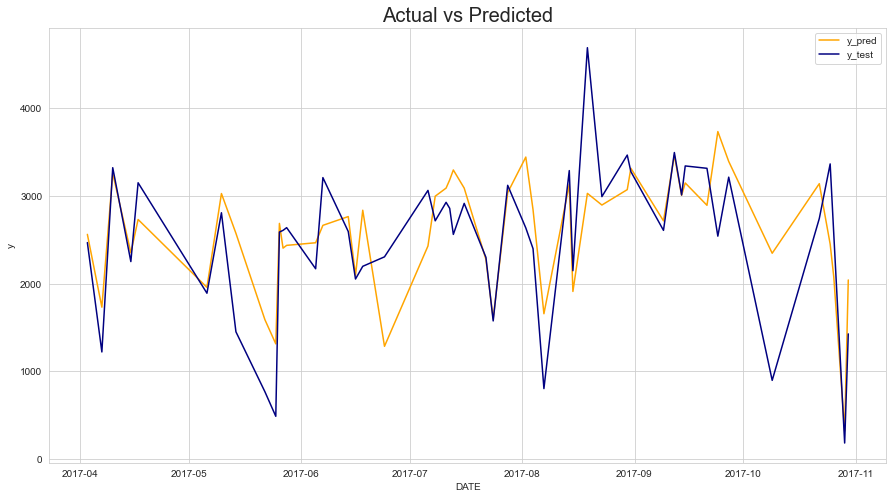

In [71]:
y_pred = nb2.get_prediction(X_test)
y_pred = y_pred.summary_frame()["mean"]

pred_df = pd.DataFrame(y_pred)
test_df = pd.DataFrame(y_test)

evaluation_df = pred_df.join(test_df)
evaluation_df.columns = ["y_pred", "y_test"]

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)

sns.lineplot(x=evaluation_df.index, y="y_pred", data=evaluation_df, color="orange", label="y_pred", ax=ax)
sns.lineplot(x=evaluation_df.index, y="y_test", data=evaluation_df, color="navy", label="y_test", ax=ax)

ax.set_title("Actual vs Predicted", fontsize=20)
ax.set_ylabel("y")

mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean absolute percentage error is: {np.round(mape, 2)*100}%")

plt.show()

## Step 6
Test goodness-of-fit of the NB2 model.

**Pearson Chi-squared test:**

$H_0$: the data follows a Negative Binomial distribution

$H_1$: the data follows a Negative Binomial distribution

$\chi^2=\sum(\frac{(y_i-\hat{y}_i)^2}{\sqrt{\hat{y_i}}})$ with DF = observations - parameters

The Pearson Chi-squared test statistic we observe in the model summary, has a p-value of 0.0.
If data followed a Negative Binomial distribution, and we ran the test 100 times we would observe this data 0 times.
Therefore, we reject the null hypothesis.

**The Likelihood-ratio (LR) test:**

The Likelihood-ratio test is used to compare how well two models fit the data.

$H_0$: Poisson model (less restrictive) is better than Negative Binomial

$H_1$: Poisson model is not better than Negative Binomial distribution

The LR test statistic is simply negative two times the difference in the fitted log-likelihoods of the two models.

$\lambda_{LR}=-2(\ln(L[poisson]) - \ln(L[NB]))$

$\lambda_{LR}=-2*(-11840-(-1328.2))$

$\lambda_{LR}=21023.6$

The Chi-squared test statistic with df 1 (extra $\alpha$ parameter), has a p-value of 0.0.
If Poisson was better than Negative Binomial, and we ran the test 100 times we would observe this data 0 times.
Therefore, we reject the null hypothesis. We conclude that Negative Binomial is better than Poisson.


